# Import necessary libraries

## Drive + pip install

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/ML/SentimentAnalysis"

/content/drive/MyDrive/ML/SentimentAnalysis


In [3]:
!pip install datasets evaluate
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. T

## Other libraries

In [4]:
import torch
from transformers import TrainerCallback
import matplotlib.pyplot as plt
import json

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Config

In [6]:
max_token_length = 128
epochs = 2
sample_used = 10
testing = True

batch_size = 64
learning_rate = 2e-5
weight_decay = 1e-3

# Data preprocessing

In [7]:
from datasets import load_dataset
dataset = load_dataset('glue', 'sst2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [9]:
import random

def random_used():
    random.seed(42)

    # Sample 500 random indices
    random_indices = random.sample(range(len(dataset["train"])), sample_used)

    # Select the samples using the indices
    dataset["train"] = dataset["train"].select(random_indices)

    # Sample 500 random indices
    random_indices = random.sample(range(len(dataset["validation"])), sample_used)

    # Select the samples using the indices
    dataset["validation"] = dataset["validation"].select(random_indices)

    # Sample 500 random indices
    random_indices = random.sample(range(len(dataset["test"])), sample_used)

    # Select the samples using the indices
    dataset["test"] = dataset["test"].select(random_indices)

if testing:
    random_used()

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 10
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 10
    })
})

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
def preprocess_function(examples):
    return tokenizer(examples["sentence"], truncation=True)

In [13]:
tokenized_train = dataset["train"].map(preprocess_function, batched=True)
tokenized_val = dataset["validation"].map(preprocess_function, batched=True)
tokenized_test = dataset["test"].map(preprocess_function, batched=True)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [14]:
tokenized_train

Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
    num_rows: 10
})

In [15]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length", max_length=max_token_length)

# Model

In [16]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [17]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Metrics

In [18]:
import evaluate

accuracy = evaluate.load("accuracy")

In [19]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Train

In [20]:
class LossHistoryCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
        self.eval_acc = []
        self.epochs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            print(logs)
            if "loss" in logs:
                self.train_loss.append(logs["loss"])
                self.epochs.append(int(logs["epoch"]))
            if "eval_loss" in logs:
                self.eval_loss.append(logs["eval_loss"])
            if "eval_accuracy" in logs:
                self.eval_acc.append(logs["eval_accuracy"])

            print(self.train_loss)
            print(self.epochs)
            print(self.eval_loss)

# Assuming you have these objects already
# model, tokenizer, train_dataset, eval_dataset

In [21]:
# Initialize the LossHistoryCallback
loss_history = LossHistoryCallback()

training_args = TrainingArguments(
    output_dir="./eval",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=weight_decay,
    save_total_limit=2,
    load_best_model_at_end=True,
    num_train_epochs=epochs,
    report_to=None,
    fp16=(device == "cuda"),
    logging_steps=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[loss_history],
)

In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.801600,0.688219,0.500000
2,0.775400,0.688167,0.400000


{'loss': 0.8016, 'grad_norm': 4.550051689147949, 'learning_rate': 1e-05, 'epoch': 1.0}
[0.8016]
[1]
[]
{'eval_loss': 0.6882187128067017, 'eval_accuracy': 0.5, 'eval_runtime': 4.0243, 'eval_samples_per_second': 2.485, 'eval_steps_per_second': 0.248, 'epoch': 1.0}
[0.8016]
[1]
[0.6882187128067017]
{'loss': 0.7754, 'grad_norm': 4.458626747131348, 'learning_rate': 0.0, 'epoch': 2.0}
[0.8016, 0.7754]
[1, 2]
[0.6882187128067017]
{'eval_loss': 0.6881669759750366, 'eval_accuracy': 0.4, 'eval_runtime': 3.5087, 'eval_samples_per_second': 2.85, 'eval_steps_per_second': 0.285, 'epoch': 2.0}
[0.8016, 0.7754]
[1, 2]
[0.6882187128067017, 0.6881669759750366]
{'train_runtime': 94.6723, 'train_samples_per_second': 0.211, 'train_steps_per_second': 0.021, 'total_flos': 662336993280.0, 'train_loss': 0.7884930670261383, 'epoch': 2.0}
[0.8016, 0.7754]
[1, 2]
[0.6882187128067017, 0.6881669759750366]


TrainOutput(global_step=2, training_loss=0.7884930670261383, metrics={'train_runtime': 94.6723, 'train_samples_per_second': 0.211, 'train_steps_per_second': 0.021, 'total_flos': 662336993280.0, 'train_loss': 0.7884930670261383, 'epoch': 2.0})

# Final evaluation

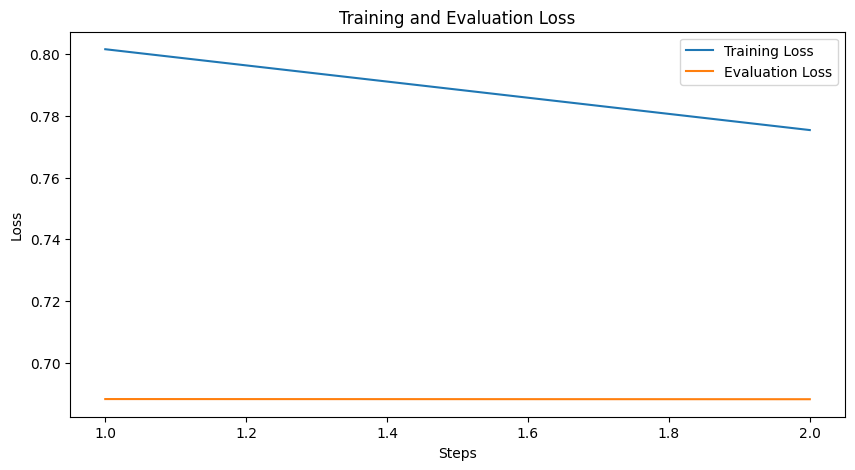

<Figure size 640x480 with 0 Axes>

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history.epochs, loss_history.train_loss, label="Training Loss")
plt.plot(loss_history.epochs, loss_history.eval_loss, label="Evaluation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Evaluation Loss")

plt.savefig("./eval/train_val_loss.png")
plt.show()
plt.clf()

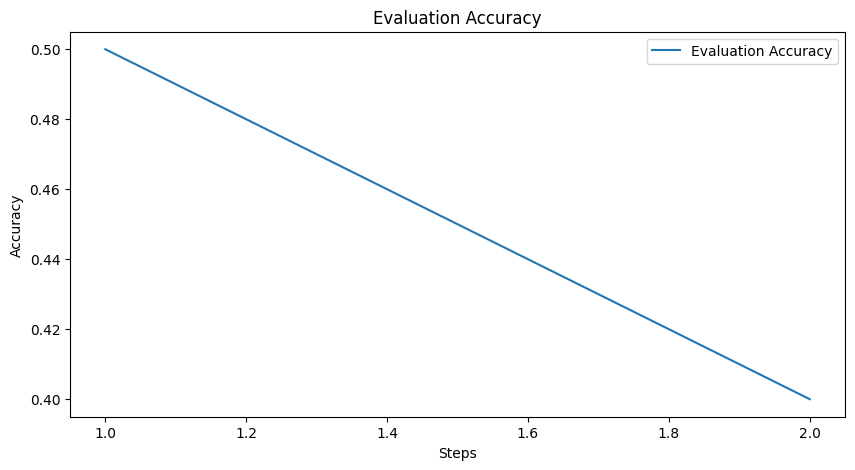

<Figure size 640x480 with 0 Axes>

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history.epochs, loss_history.eval_acc, label="Evaluation Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Evaluation Accuracy")

plt.savefig("./eval/val_acc.png")
plt.show()

plt.clf()

In [25]:
predictions, labels, metrics = trainer.predict(tokenized_val)

In [26]:
data_dict = compute_metrics((predictions, labels))

In [27]:
data_dict_new = trainer.evaluate()
for key, item in data_dict_new.items():
    data_dict[key] = item

with open("./eval/final_eval.json", "w") as file:
    json.dump(data_dict, file)

data_dict

{'eval_loss': 0.6881669759750366, 'eval_accuracy': 0.4, 'eval_runtime': 2.8337, 'eval_samples_per_second': 3.529, 'eval_steps_per_second': 0.353, 'epoch': 2.0}
[0.8016, 0.7754]
[1, 2]
[0.6882187128067017, 0.6881669759750366, 0.6881669759750366]


{'accuracy': 0.4,
 'eval_loss': 0.6881669759750366,
 'eval_accuracy': 0.4,
 'eval_runtime': 2.8337,
 'eval_samples_per_second': 3.529,
 'eval_steps_per_second': 0.353,
 'epoch': 2.0}

# Inference

In [28]:
text = "This sucks ass"

In [29]:
from transformers import pipeline

model_name = "stevhliu/my_awesome_model"

def inference_from_pipeline(text, model_name):
    classifier = pipeline("sentiment-analysis", model=model_name)
    return classifier(text)

def inference_directly(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt")

    # Ensure the inputs are on the correct device
    inputs = {k: v.to(trainer.model.device) for k, v in inputs.items()}

    # Generate predictions
    with torch.no_grad():
        outputs = trainer.model(**inputs)
        logits = outputs.logits

    predictions = np.argmax(logits, axis=1)
    pred_class = trainer.model.config.id2label[int(predictions)]

    #decoded_preds = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return pred_class, logits


In [30]:
inference_directly(text)

('NEGATIVE', tensor([[ 0.0202, -0.0453]]))